In [2]:
import pandas as pd
import numpy as np
import math
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
import time
from datetime import date
from tqdm.notebook import tqdm as tqdm
from matplotlib import cm
import ast
from ipynb.fs.defs.functions import getName
from ipynb.fs.defs.functions import new_route

table = pd.read_csv("../orari/route.csv", delimiter=";")
time_table = pd.read_csv("../orari/route_time.csv", delimiter=";")
path = "../orari/IndirizziBiblio_21-10-2019.ods"
indirizzi = read_ods(path, 'Questionari_normalizza')
indirizzi=indirizzi.astype({'Cap':'int32'})

dft = pd.read_csv("../distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
num_orders = pd.read_csv("../num_orders.csv", delimiter=";", encoding = "ISO-8859-1")
orders = pd.read_csv("../request_cr.csv", delimiter=",", encoding = "ISO-8859-1")
def translate_name(dframe, fur):
    df = pd.DataFrame({})
    for d in fur.columns:
        df1 = pd.DataFrame([getName(dframe, x) for x in list(fur[d].dropna())], columns = [d])
        df = pd.concat([df,df1], ignore_index=False, axis=1)
    return df
def get_row(df, string):
    return pd.Series(df.index).str.contains(string.strip(), case=False)

def get_column(df, string):
    return pd.Series(df.columns).str.contains(string.strip(), case=False)
def getName(df, nome):
    if nome.lower() == "crema":
        nome ="crema,"
    city = df[get_row(df, nome).values].index[0]

    return city


# Analisi first schedule

In [2]:
first_schedule = translate_name(dft, table)

In [3]:
first_schedule

,lunedi,martedi,mercoledi,giovedi,venerdi
0,"Sesto ed Uniti, Roma, 4","Manerbio, INSURREZIONE NAZIONALE","Paderno Ponchielli, Municipio, 3","Manerbio, INSURREZIONE NAZIONALE","Capergnanica, XI febbraio, 7"
1,"Grumello Cremonese ed Uniti, Roma, 2","Cremona, Felice Cavallotti, 2","San Bassano, Mons. Frosi","Cremona, Sesto 39","Monte Cremasco, Roma, 12"
2,"Pizzighettone, Giuseppe Garibaldi, 18","Casalpusterlengo, Pusterla 7","Castelleone, Roma, 67","Pizzighettone, Giuseppe Garibaldi, 18","Spino d'Adda, Circonvallazione, 13"
3,"Montodine, XXV Aprile, 10","Cremona, Ugolani Dati, 4","Spino d'Adda, Circonvallazione, 13","Casalpusterlengo, Pusterla 7","Pandino, Castello, 15"
4,"Ripalta Cremasca, Roma, 5","Crema, Civerchi, 9","Romanengo, Guaiarini, 14","Cremona, Ugolani Dati, 4","Casaletto Vaprio, Maggiore, 7"
5,"Capralba, Piave, 2","Bonemerse, Roma, 25","Pandino, Castello, 15","Cremona, Ugolani Dati, 4","Bagnolo Cremasco, Roma, 3"
6,"Casale Cremasco-Vidolasco, Roma, 56","Sospiro, Tosi","Palazzo Pignano, Marco Polo, 31","Pizzighettone, Giuseppe Garibaldi, 18","Crema, Civerchi, 9"
7,"Camisano, Trieste, 57","Vailate, Dante Alighieri, 7","Rivolta d'Adda, Stefano Renzi, 5","Grontardo, Roma, 16","Vaiano Cremasco, Gloriosi Caduti, 3"
8,"Trigolo, Roma, 26","Pianengo, Nenni","Crema, Civerchi, 9","Pescarolo ed Uniti, Giuseppe Mazzini, 73","Trescore Cremasco, Vittorio Veneto, 1"
9,"Castelleone, Roma, 67","Vescovato, Roma, 44","Cremona, Palosca n. 2","Izano, Gerardo da Izano, 4/C","Rivolta d'Adda, Stefano Renzi, 5"


In [4]:
schedule_cities = []
for i in first_schedule.columns:
    schedule_cities = schedule_cities + list(first_schedule[i].dropna())
total_cities = indirizzi[indirizzi['Calendarizzata (sì/no)'] == 'sì']
num_of_cities = len(set(schedule_cities))
print(f"rapporto tra il numero di città nella schedulazione iniziale e quelle disponibili calendarizzate: la schedulazione non presenta città mancanti\n rapporto: {num_of_cities/len(total_cities)}")
print(f"numero totali di città considerabili: {len(total_cities)}")

rapporto tra il numero di città nella schedulazione iniziale e quelle disponibili calendarizzate: la schedulazione non presenta città mancanti
 rapporto: 1.0
numero totali di città considerabili: 64


In [31]:
print(len(indirizzi), len(total_cities))

105 64


In [29]:
fur1 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
fur2 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")



1, lunedi, 292.0
1, martedi, 324.0
1, mercoledi, 311.0
1, giovedi, 231.0
1, venerdi, 279.0
2, martedi, 245.0
2, mercoledi, 153.0
2, giovedi, 278.0


# Analisi indirizzi biblio

In [5]:
comuni = total_cities['Comune'].dropna()
com_distribution = list(set([(x, list(comuni).count(x)) for x in list(comuni)]))
print(f"numero di comuni in cui sono presenti le città calendarizzate: {len(com_distribution)}")
print("città con ripetizioni:")
for x in com_distribution:
    if x[1] > 1:
        print(f"{x[0]}, {x[1]}")

province = total_cities['Provincia'].dropna()
pro_distribution = list(set([(x, list(province).count(x)) for x in list(province)]))
print(f"numero di province in cui sono presenti le città calendarizzate: {len(pro_distribution)}")
print(f"distribuzione province:")
for x in pro_distribution: 
    print(f"{x[0]}, {x[1]}")
    
print("da cui si sottolineano le tre città di un'altra provincia:")
print(total_cities[total_cities['Provincia'] != 'CR'][['Comune', 'Provincia']])

numero di comuni in cui sono presenti le città calendarizzate: 60
città con ripetizioni:
Cremona, 4
Crema, 2
numero di province in cui sono presenti le città calendarizzate: 4
distribuzione province:
BS, 1
LO, 1
CR, 61
MN, 1
da cui si sottolineano le tre città di un'altra provincia:
              Comune Provincia
18  Casalpusterlengo        LO
69          Manerbio        BS
70           Viadana        MN


In [8]:
l = []
for d in first_schedule.columns:
    l += list(first_schedule[d].dropna())
city_distribution = list(set([(x, l.count(x)) for x in l]))

In [29]:
city_distribution.sort()
multi_occ = pd.Series(data = [0]*3, index = [2,3,4])
for el in city_distribution:
    if(el[1]>1):
        multi_occ[el[1]] +=1
print(f"Biblitoeche con più di un'occorrenza: {sum(multi_occ.values)}\n\n")
for el in multi_occ:
    print(f"Biblitoeche con {multi_occ[multi_occ == el].index[0]} occorrenze: {el}")

Biblitoeche con più di un'occorrenza: 21


Biblitoeche con 2 occorrenze: 18
Biblitoeche con 3 occorrenze: 2
Biblitoeche con 4 occorrenze: 1


# Analisi scambi biblioteche

In [ ]:

week = {0: "lunedi", 1:"martedi", 2:"mercoledi", 3:"giovedi", 4:"venerdi", 5:"sabato", 6:"domenica"}
dal = orders['data_richiesta'][0].split(" ")[0]
al = orders['data_richiesta'][len(orders)-1].split(" ")[0]
print(f"numero ordini: {len(orders)}, dal {dal} al {al}")


duemila_16 = []
duemila_17 = []
duemila_18 = []

for i in tqdm(range(len(orders))):
    if orders.loc[i]['data_richiesta'].split(" ")[0].split("-")[0] == '2016':
        duemila_16.append(orders.loc[i])
    elif orders.loc[i]['data_richiesta'].split(" ")[0].split("-")[0] == '2017':
        duemila_17.append(orders.loc[i])
    elif orders.loc[i]['data_richiesta'].split(" ")[0].split("-")[0] == '2018':
        duemila_18.append(orders.loc[i])
print(f"i numeri di ordini sono divisi in: 2016: {len(duemila_16)} " + f"2017: {len(duemila_17)} " + f"2018: {len(duemila_18)}")

In [33]:
print(f"i numeri di ordini sono divisi in: 2016: {len(duemila_16)} " + f"2017: {len(duemila_17)} " + f"2018: {len(duemila_18)}")

i numeri di ordini sono divisi in: 2016: 54751 2017: 52775 2018: 52116


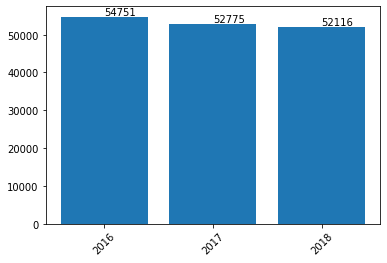

In [47]:
plt.bar(['2016', '2017', '2018'] ,[len(duemila_16), len(duemila_17), len(duemila_18)])
for el in range(3):
    plt.text(['2016', '2017', '2018'][el], [len(duemila_16), len(duemila_17), len(duemila_18)][el]+500, s=str([len(duemila_16), len(duemila_17), len(duemila_18)][el]))
#plt.text(['2016', '2017', '2018'], [len(duemila_16), len(duemila_17), len(duemila_18)], s=f"[len(duemila_16), len(duemila_17), len(duemila_18)]")
plt.xticks(rotation = 45)
plt.show()

In [64]:
not_present_city = []
elenco = list(set(list(orders["biblioteca_destinazione"]) + list(orders["biblioteca_partenza"])))
for el in elenco:
    try:
        getName(dft, el)
    except:
        not_present_city.append(el)

C:\Users\Alberto\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [68]:
orders

,loan_id,data_richiesta,biblioteca_destinazione,biblioteca_partenza
0,22690933,2016-01-01 09:35:10,BONEMERSE,RIVOLTA D'ADDA
1,22690934,2016-01-01 11:40:36,ROMANENGO,RIVOLTA D'ADDA
2,22690935,2016-01-01 17:54:48,Agnadello,RIVOLTA D'ADDA
3,22690936,2016-01-01 21:10:08,SPINO D'ADDA,RIVOLTA D'ADDA
4,22690937,2016-01-01 21:11:29,SPINO D'ADDA,RIVOLTA D'ADDA
...,...,...,...,...
159637,38869450,2018-10-22 11:35:32,BAGNOLO CREMASCO,RIVOLTA D'ADDA
159638,38879783,2018-12-20 09:49:39,CREMA,BRESCIA
159639,38880310,2018-11-07 17:16:37,PANDINO,PIANENGO
159640,38889304,2018-12-12 15:33:18,BRESCIA,CASALMAGGIORE


In [2]:
def manage_exception(string):
    if(string.lower().strip() == 'piadena drizzona'):
        return 'Piadena, Platina, 40'
    elif(string.lower().strip() == 'brescia'):
        return 'manerbio, insurrezione nazionale'
    elif(string.lower().strip() == 'centro fumetto a. pazienza' or string.lower().strip() == 'cremona. la piccola biblioteca' or string.lower().strip() == 'uff. bib. cremona'):
        return 'cremona, ugolani dati, 4'
    elif(string.lower().strip() == 'casale cremasco vidolasco'):
        return 'Casale Cremasco-Vidolasco, Roma, 56'
    elif(string.lower().strip() == 'cremona-m.i.t.o.'):
        return 'Cremona, Palosca n. 2'
    elif(string.lower().strip() == 'cremona - manin (scolastica)'):
        return 'Cremona, Felice Cavallotti, 2'
    elif(string.lower().strip() == 'gadesco pieve delmona'):
        return 'Gadesco-Pieve Delmona, Giovanni Lonati 9'
    elif(string.lower().strip() == 'cremona - cda'):
        return 'cremona, sesto 39'
    elif(string.lower().strip() == 'crema'):
        return 'Crema, Civerchi, 9'
    elif(string.lower().strip() == 'martignana di po, libertà, 64'):
        return 'martignana di po, libertà, 64'
    else:
        return string
    
start = []
destination = []
for city in dft.columns:
    try:
        start.append((city, len([x for x in orders["biblioteca_partenza"] if getName(dft, manage_exception(x))==city])))
        end.append((city, len([x for x in orders["biblioteca_destinazione"] if getName(dft, manage_exception(x))==city])))
    except:
        None


In [6]:
error = []
uguali = 0
for i in range(len(orders)):
    x=orders.iloc[i]
    try:
        a=getName(dft, manage_exception(x["biblioteca_partenza"]))
        b=getName(dft, manage_exception(x["biblioteca_destinazione"]))
        if a==b:
            uguali += 1
    except:
        None

C:\Users\Alberto\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [7]:
uguali

6161

In [9]:
orders[orders["biblioteca_destinazione"]=="UNIONE MUNICIPIA"]

,loan_id,data_richiesta,biblioteca_destinazione,biblioteca_partenza
316,22711163,2016-01-07 15:53:14,UNIONE MUNICIPIA,UNIONE MUNICIPIA
733,22734189,2016-01-10 17:54:13,UNIONE MUNICIPIA,GADESCO PIEVE DELMONA
917,22740881,2016-01-10 18:07:54,UNIONE MUNICIPIA,BRESCIA
1142,22751484,2016-01-12 14:51:10,UNIONE MUNICIPIA,CAPRALBA
1219,22754484,2016-01-13 11:26:42,UNIONE MUNICIPIA,SOLAROLO RAINERIO
...,...,...,...,...
158075,38083675,2018-11-29 15:28:57,UNIONE MUNICIPIA,SPINO D'ADDA
158093,38085460,2018-12-27 10:02:10,UNIONE MUNICIPIA,PIADENA DRIZZONA
158501,38129075,2018-11-23 18:00:24,UNIONE MUNICIPIA,CREMA
158515,38131103,2018-10-29 22:33:20,UNIONE MUNICIPIA,BRESCIA


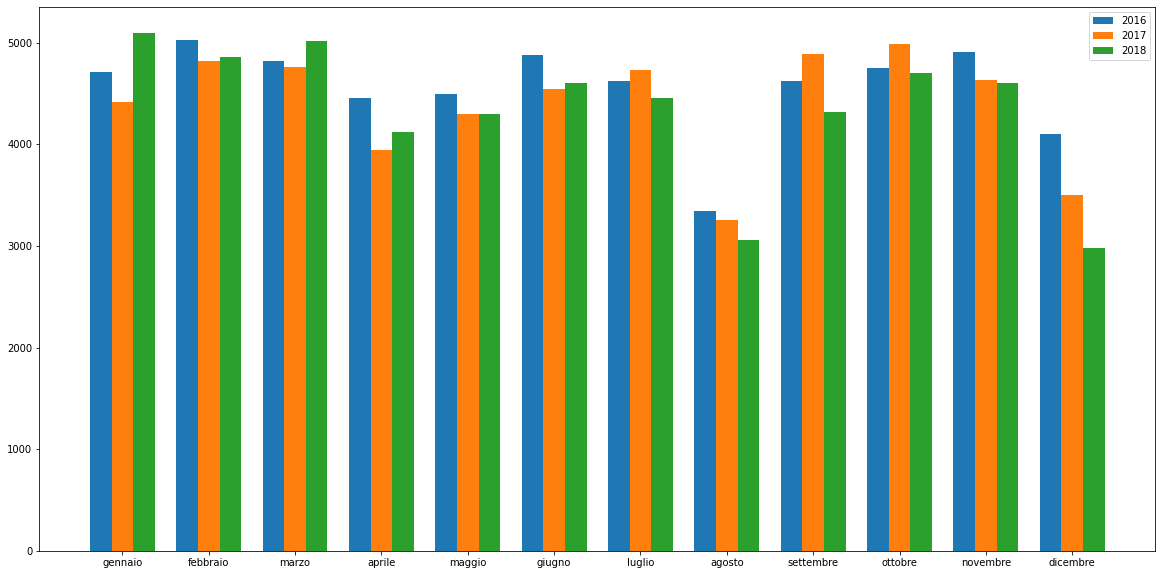

In [67]:
months = ["gennaio", "febbraio", "marzo", "aprile", "maggio", "giugno", "luglio", "agosto", "settembre", "ottobre", "novembre", "dicembre"]


def month_dist(l):
    freq = pd.Series(data = [0]*12, index = months)
    for x in l:
        d = x['data_richiesta'].split(" ")[0]
        m = int(d.split("-")[1])
        freq[m-1] = freq[m-1] + 1
    return freq
w = 0.25

# Set position of bar on X axis
r2 = np.arange(12)
r1 = [x - w for x in r2]
r3 = [x + w for x in r2]

fig, ax = plt.subplots(figsize=[20, 10])
r_16 = ax.bar(r1,month_dist(duemila_16), width = w, label = '2016')
r_17 = ax.bar(r2,month_dist(duemila_17), width = w, label = '2017')
r_18 = ax.bar(r3,month_dist(duemila_18), width = w, label = '2018')

plt.xticks([r for r in range(len(months))], months)
plt.legend()
plt.show()

In [65]:
freq = pd.Series(data = [0,0,0,0,0,0,0], index = ["lunedi", "martedi","mercoledi", "giovedi","venerdi", "sabato", "domenica"])


for x in orders['data_richiesta']:
    d = x.split(' ')[0]
    n = week.get(date.fromisoformat(d).weekday())
    freq[n] = freq[n] + 1

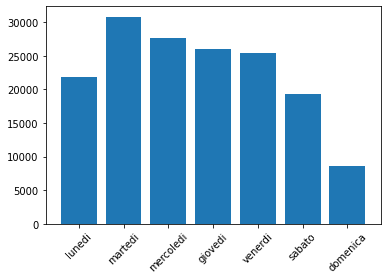

In [66]:
plt.bar(freq.keys() ,freq.values)
plt.xticks(rotation = 45)
plt.show()

In [2]:
def divide_daily_orders(df, dframe_orders):
    week = {0: "lunedi", 1:"martedi", 2:"mercoledi", 3:"giovedi", 4:"venerdi", 5:"sabato", 6:"domenica"}
    not_considered = 0
    freq = pd.Series(data = [[],[],[],[],[],[],[]], index = ["lunedi", "martedi","mercoledi", "giovedi","venerdi", "sabato", "domenica"])
    for i in tqdm(range(len(dframe_orders))):
        try:
            row = dframe_orders.iloc[i]
            orig = getName(df, manage_exception(row['biblioteca_partenza']))
            dest = getName(df, manage_exception(row['biblioteca_destinazione']))
            if orig == dest:
                not_considered = not_considered + 1
                continue
            try:
                x = row['data_richiesta']
                d = x.split(' ')[0]
                n = week.get(date.fromisoformat(d).weekday())
                temp = [orig, dest, n]
                freq[n].append(temp)
            except:
                print(x)
                break
        except:
            not_considered = not_considered + 1
            continue
                
    return freq, not_considered

#f, not_considered = divide_daily_orders(dft, orders)
#biblioteca_destinazione
#biblioteca_partenza
#data_richiesta
#print(f)

In [3]:
#f.to_csv("frequences.csv", encoding = "ISO-8859-1")

k = pd.read_csv("FrequencesResults/frequences.csv", encoding = "ISO-8859-1", index_col=0, header=0, squeeze = True)

In [4]:
week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi", "sabato", "domenica"]
for d in week:
    k[d] = ast.literal_eval(k[d])

In [5]:
def getOccurenceDays(fur1, fur2, city):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    l = []
    for d in fur1.columns:
        cur_route1 = fur1[d].dropna()[1:len(fur1[d].dropna())-1]
            
        if city in list(cur_route1):
            l.append(week.index(d))
    
    for d in fur2.columns:
        cur_route2 = fur2[d].dropna()[1:len(fur2[d].dropna())-1]
            
        if city in list(cur_route2):
            l.append(week.index(d))
          
    return list(set(l))

def getOccurenceNumber(fur1, fur2, city):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    l = []
    for d in fur1.columns:
        cur_route1 = fur1[d].dropna()[1:len(fur1[d].dropna())-1]
            
        if city in list(cur_route1):
            l.append(week.index(d))
    
    for d in fur2.columns:
        cur_route2 = fur2[d].dropna()[1:len(fur2[d].dropna())-1]
            
        if city in list(cur_route2):
            l.append(week.index(d))
          
    return len(l)

#frequenza degli scambi tra i e j con richiesta nel giorno g
def e (g, i, j, k):
    v =[i, j, g]
    return len([index for index, value in enumerate(k[g]) if value == v])
#e('martedi', 'Offanengo, Clavelli Martini, 5', 'Soncino, Dante Alighieri, 23')

def dist(s, e):
#     if s == e:
#         return 7
    if s < e:
        return e-s
    if s >= e:
        return 7-(s-e)

def f(i, g, j, h, fur1, fur2, k):
    w = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi", "sabato", "domenica"]
    g = week.index(g)
    s = 0
    f1_occurrences = getOccurenceDays(fur1, fur2, i)
    
    try:
        q = list([x for x in f1_occurrences if x>=g] + [x for x in f1_occurrences if x<g])[-1]
    except:
        print(i, g, j, h, sep="    ")
        
    if(q<g):
        for m in range(q, g):
            s += dist(m, w.index(h)) * e(m, i, j, k)
    elif(q>=g):
        for m in list(range(q, 7)) + list(range(0, g)):
            s += dist(m, w.index(h)) * e(m, i, j, k)
    return s       

# pick-up & deliver day analysis

In [6]:
#works with 2opt or ls schedulation
def getOccurenceDays(fur1, city):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    l = []
    for d in fur1.columns:
        cur_route1 = fur1[d].dropna()[1:len(fur1[d].dropna())-1]
            
        if city in list(cur_route1):
            l.append(week.index(d))
          
    return list(set(l))

def take_deliver(fur1, fur2, s, d, day):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    f1_occurrences = getOccurenceDays(fur1, s)
    if f1_occurrences:
        f1_occurrences = list([x for x in f1_occurrences if x>week.index(day)] + [x for x in f1_occurrences if x<=week.index(day)])[0]
    else:
        f1_occurrences = 10
    f2_occurrences = getOccurenceDays(fur2, s)
    if f2_occurrences:
        f2_occurrences = list([x for x in f2_occurrences if x>week.index(day)] + [x for x in f2_occurrences if x<=week.index(day)])[0]
    else:
        f2_occurrences = 10
    
    if f1_occurrences==f2_occurrences==10:
        print("città non nella schedulazione", s, sep=" - ")
    
    take = [f1_occurrences, f2_occurrences].index(min([f1_occurrences, f2_occurrences]))
    day = week[min([f1_occurrences, f2_occurrences])]
    pickup_day = min(f1_occurrences, f2_occurrences)
    
    f1_occurrences = getOccurenceDays(fur1, d)
    if f1_occurrences:
        f1_occurrences = list([x for x in f1_occurrences if x>week.index(day)] + [x for x in f1_occurrences if x<=week.index(day)])[0]
    else:
        f1_occurrences = 10
        
    f2_occurrences = getOccurenceDays(fur2, d)
    if f2_occurrences:
        f2_occurrences = list([x for x in f2_occurrences if x>week.index(day)] + [x for x in f2_occurrences if x<=week.index(day)])[0]
    else:
        f2_occurrences = 10
    deliver = [f1_occurrences, f2_occurrences].index(min([f1_occurrences, f2_occurrences]))
    
    return take, deliver, pickup_day, min(f1_occurrences, f2_occurrences)

def getDistance(s, e):
#     if s == e:
#         return 7
    if s < e:
        return e-s
    if s >= e:
        return 7-(s-e)

def get_stats(occorrenze, fur1, fur2):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi", "sabato", "domenica"]
    freq1 = pd.Series(data = [0,0,0], index = ["pickup", "deliver", "both"])
    freq2 = pd.Series(data = [0,0,0], index = ["pickup", "deliver", "both"])
    mean_service_time = pd.Series(data = [0,0], index = ["total", "n"])
    mean_pickup_time = pd.Series(data = [0,0], index = ["total", "n"])
    
    for day_i in tqdm(range(len(occorrenze))):
        day = occorrenze[day_i]
        for order in day:
            s = order[0]
            d = order[1]
            order_day = order[2]
            #gestire sabato e domenica
            if order_day=="sabato" or order_day=="domenica":
                take, deliver, pickup_day, deliver_day = take_deliver(fur1, fur2, s, d, "venerdi")
            elif order_day == None:
                print(order)
            else:
                take, deliver, pickup_day, deliver_day = take_deliver(fur1, fur2, s, d, order_day)
                
#             if take==deliver==0:
#                 freq1["both"] += 1
#             if take==deliver==1:
#                 freq2["both"] += 1
#             if take==0 and deliver == 1:
#                 freq1["pickup"] +=1
#                 freq2["deliver"] += 1 
#             if take==1 and deliver == 0:
#                 freq2["pickup"] +=1
#                 freq1["deliver"] += 1
            
            mean_service_time["total"] += getDistance(week.index(order_day), deliver_day)
            mean_service_time["n"] += 1
            mean_pickup_time["total"] += getDistance(week.index(order_day), pickup_day)
            mean_pickup_time["n"] += 1
    #return freq1, freq2, [round(mean_service_time["total"]/mean_service_time["n"], 2)], [round(mean_pickup_time["total"]/mean_pickup_time["n"], 2)]
    return [round(mean_service_time["total"]/mean_service_time["n"], 2)], [round(mean_pickup_time["total"]/mean_pickup_time["n"], 2)]

In [12]:
mp_v = pd.read_csv("FrequencesResults/mp_variables.csv", sep=";", index_col=0)
ms_v = pd.read_csv("FrequencesResults/ms_variables.csv", sep=";", index_col=0)

In [13]:
fur1 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
fur2 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")
#fr1, fr2, ms, mp = get_stats(k, fur1, fur2)
ms, mp = get_stats(k, fur1, fur2)

In [15]:
ms_v.loc["FOSS_MVLS"] = ms
ms_v.to_csv("FrequencesResults/ms_variables.csv", sep=";", encoding = "ISO-8859-1")
mp_v.loc["FOSS_MVLS"] = mp
mp_v.to_csv("FrequencesResults/mp_variables.csv", sep=";", encoding = "ISO-8859-1")

In [29]:
#fr1.to_csv("FrequencesResults/fr1_original_greedy.csv", encoding = "ISO-8859-1")
#fr2.to_csv("FrequencesResults/fr2_original_greedy.csv", encoding = "ISO-8859-1")
#pd.Series({"ms": ms, "mp": mp}).to_csv("greedy_MVLS_variables.csv", encoding = "ISO-8859-1")
pd.Series({"ms": ms}).to_csv("FrequencesResults/oss_greedy_variables.csv", encoding = "ISO-8859-1")

In [22]:
mp_v.values

array([[3.07],
       [3.19],
       [3.88],
       [3.49],
       [3.22],
       [3.48],
       [3.06],
       [3.07]])

# w-days and mean pick-up time comparison

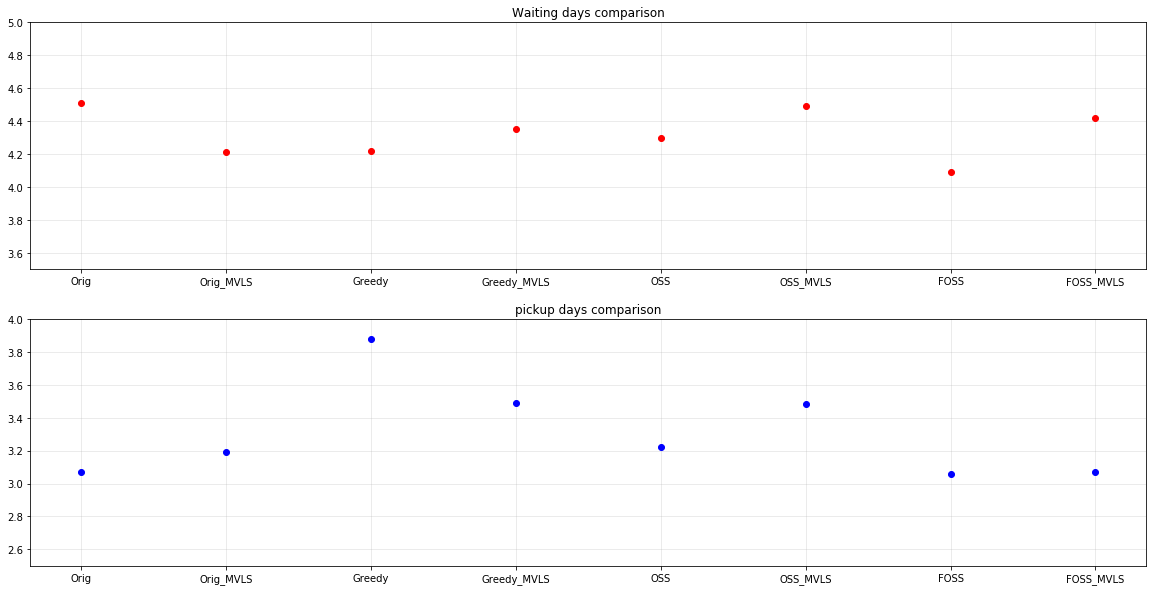

In [23]:
mp_v = pd.read_csv("FrequencesResults/mp_variables.csv", sep=";", index_col=0)
ms_v = pd.read_csv("FrequencesResults/ms_variables.csv", sep=";", index_col=0)

plt.figure(figsize=[20,10])

plt.subplot(211)
plt.title("Waiting days comparison")
plt.plot(ms_v.values, 'or')
plt.xticks(range(8), ["Orig", "Orig_MVLS", "Greedy", "Greedy_MVLS", "OSS", "OSS_MVLS", "FOSS", "FOSS_MVLS"])
plt.ylim([3.5,5])
plt.grid(alpha=0.3)

plt.subplot(212)
plt.title("pickup days comparison")
plt.plot(mp_v.values, 'ob')
plt.xticks(range(8), ["Orig", "Orig_MVLS", "Greedy", "Greedy_MVLS", "OSS", "OSS_MVLS", "FOSS", "FOSS_MVLS"])
plt.ylim([2.5,4])
plt.grid(alpha=0.3)

# plt.subplot(122)
# plt.title("Mean pickup time")
# plt.plot(mp, 'ob')
# plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
# plt.ylim([2.5,5])
# plt.grid(alpha=0.3)

plt.show()

## charts fur 1

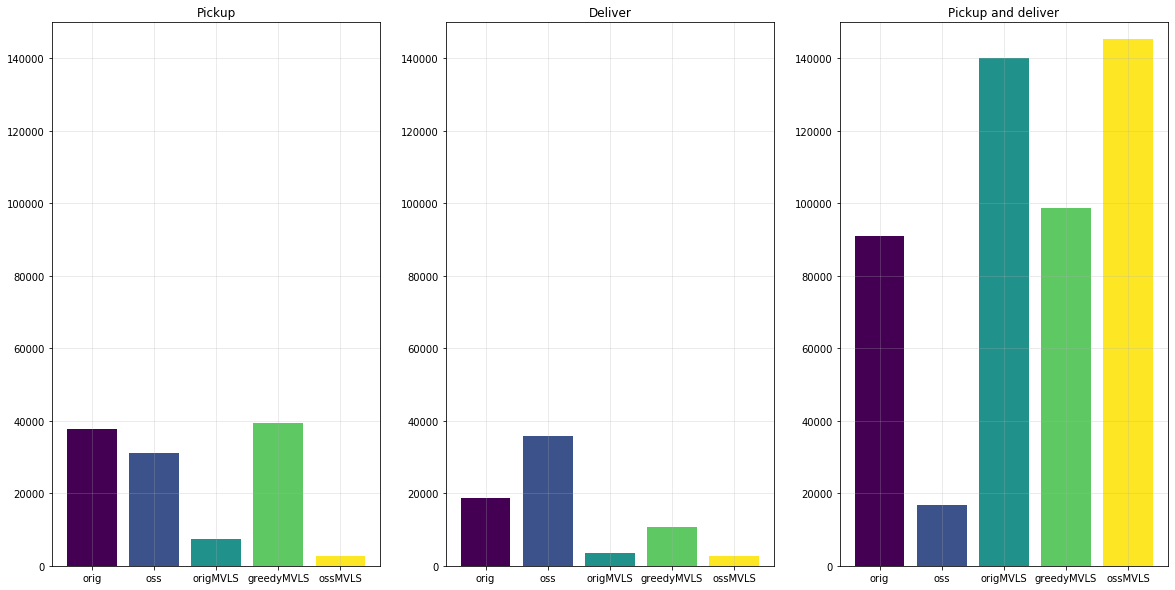

In [76]:
plt.figure(figsize=[20,10])
viridis = cm.get_cmap('viridis', 5)
plt.title("F1 comparison")
plt.subplot(131)
plt.title("Pickup")
plt.bar(range(5), [fr1_orig.loc["pickup"][0], 
                   fr1_oss.loc["pickup"][0], 
                   fr1_orig_MVLS.loc["pickup"][0], 
                   fr1_greedy_MVLS.loc["pickup"][0], 
                   fr1_oss_MVLS.loc["pickup"][0]],
                   color = [x for x in viridis.colors])
plt.ylim([0,150000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(132)
plt.title("Deliver")
plt.bar(range(5), [fr1_orig.loc["deliver"][0], 
                   fr1_oss.loc["deliver"][0], 
                   fr1_orig_MVLS.loc["deliver"][0], 
                   fr1_greedy_MVLS.loc["deliver"][0], 
                   fr1_oss_MVLS.loc["deliver"][0]],
        color = [x for x in viridis.colors])
plt.ylim([0,150000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(133)
plt.title("Pickup and deliver")
plt.bar(range(5), [fr1_orig.loc["both"][0], 
                   fr1_oss.loc["both"][0], 
                   fr1_orig_MVLS.loc["both"][0], 
                   fr1_greedy_MVLS.loc["both"][0], 
                   fr1_oss_MVLS.loc["both"][0]],
        color = [x for x in viridis.colors])
plt.ylim([0,150000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.show()

# charts fur2

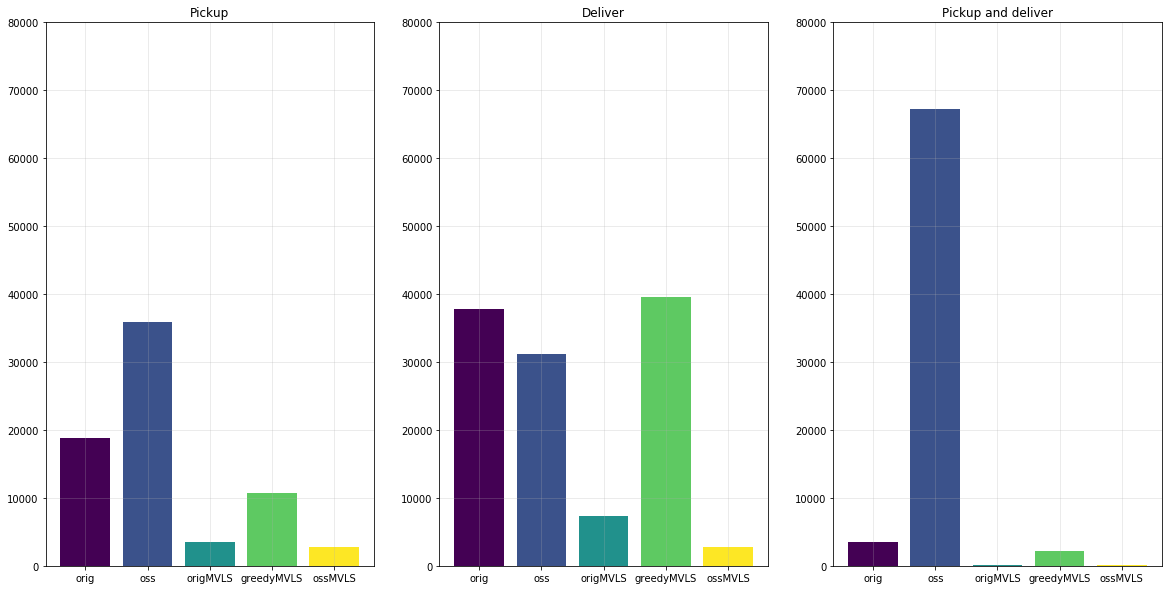

In [77]:
plt.figure(figsize=[20,10])
plt.title("F2 comparison")
plt.subplot(131)
plt.title("Pickup")
plt.bar(range(5), [fr2_orig.loc["pickup"][0], 
                   fr2_oss.loc["pickup"][0], 
                   fr2_orig_MVLS.loc["pickup"][0], 
                   fr2_greedy_MVLS.loc["pickup"][0], 
                   fr2_oss_MVLS.loc["pickup"][0]],
        color = [x for x in viridis.colors])
plt.ylim([0,80000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(132)
plt.title("Deliver")
plt.bar(range(5), [fr2_orig.loc["deliver"][0], 
                   fr2_oss.loc["deliver"][0], 
                   fr2_orig_MVLS.loc["deliver"][0], 
                   fr2_greedy_MVLS.loc["deliver"][0], 
                   fr2_oss_MVLS.loc["deliver"][0]],
        color = [x for x in viridis.colors])
plt.ylim([0,80000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.subplot(133)
plt.title("Pickup and deliver")
plt.bar(range(5), [fr2_orig.loc["both"][0], 
                   fr2_oss.loc["both"][0], 
                   fr2_orig_MVLS.loc["both"][0], 
                   fr2_greedy_MVLS.loc["both"][0], 
                   fr2_oss_MVLS.loc["both"][0]],
        color = [x for x in viridis.colors])
plt.ylim([0,80000])
plt.xticks(range(5), ["orig", "oss", "origMVLS", "greedyMVLS", "ossMVLS"])
plt.grid(alpha=0.3)

plt.show()

In [4]:
mwdays = pd.read_csv("FrequencesResults/week_orders_mwdays.csv", encoding = "ISO-8859-1", index_col=0, header = None, squeeze = True)
mwpudays = pd.read_csv("FrequencesResults/week_orders_mwpudays.csv", encoding = "ISO-8859-1", index_col=0, header= None, squeeze = True)

In [38]:
week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi", "sabato", "domenica"]
for d in week:
    mwdays[d] = ast.literal_eval(mwdays[d])
    
for d in week:
    mwpudays[d] = ast.literal_eval(mwpudays[d])

In [ ]:
x = mwdays["lunedi"][:]
x.sort()
d = list(set([x.count(d) for d in x]))
data = pd.Series(d, list(set(x)))

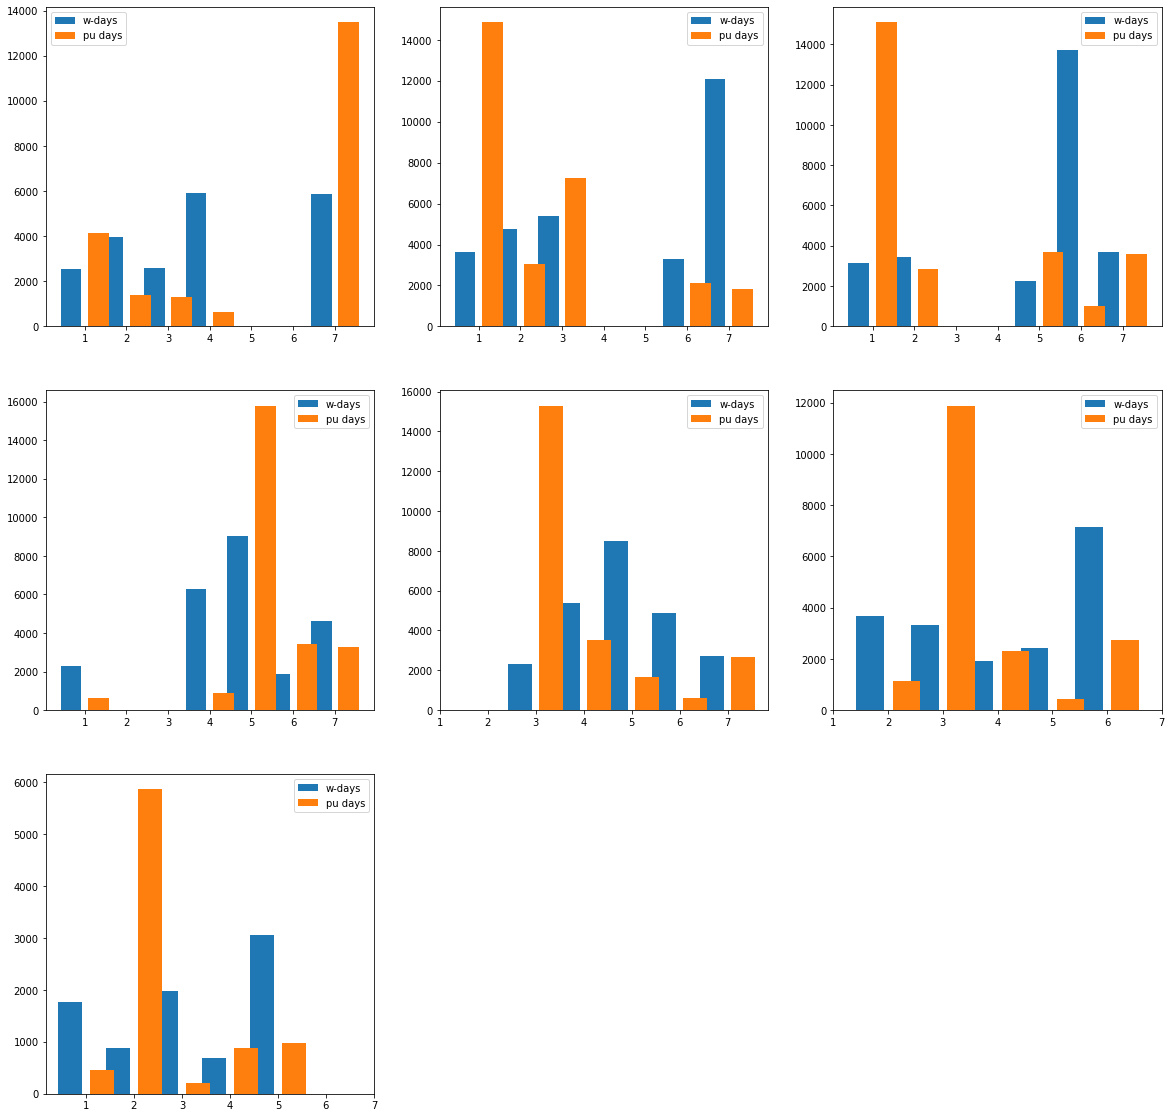

In [86]:
plt.figure(figsize=[20,20])
n = 331
w = .33
for day in week:
    x = mwdays[day][:]
    y = mwpudays[day][:] 
    d1 = list(set([x.count(d) for d in x]))
    d2 = list(set([y.count(d) for d in y]))
    x = pd.Series(d1, list(set(x)))
    y = pd.Series(d2, list(set(y)))
    plt.subplot(n) 
    plt.bar([a-w for a in x.index], x.values, label = "w-days", width = .5)
    plt.bar([a+w for a in y.index], y.values, label = "pu days", width = .5)
    plt.xticks(range(1, 8), range(1, 8))
    plt.legend()
    n += 1
plt.show()